In [2]:
#load 6 csv files
import pandas as pd
from pathlib import Path
import hvplot.pandas
%matplotlib inline

In [3]:
#Tensor Flow Model

In [4]:
import numpy as np



In [5]:
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [8]:
# Load the py-trends data for Bitcoin
pytrends_df = pd.read_csv('../resources/btc-pytrends.csv', index_col= "Day", infer_datetime_format=True, parse_dates=True)
pytrends_df = pytrends_df.rename(columns={'Bitcoin':'Pytrends'})
pytrends_df

,Pytrends
Day,
2021-10-04,40
2021-10-05,47
2021-10-06,59
2021-10-07,49
2021-10-08,45
...,...
2022-03-31,38
2022-04-01,37
2022-04-02,34


In [10]:
crypto_path = pd.read_csv('../resources/BTC-USD.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)
bitcoin_df = crypto_path.drop(columns = ['Open', 'High', 'Low', 'Adj Close', 'Volume'])
bitcoin_df

,Close
Date,
2021-10-04,49112.90234
2021-10-05,51514.81250
2021-10-06,55361.44922
2021-10-07,53805.98438
2021-10-08,53967.84766
...,...
2022-03-30,47062.66406
2022-03-31,45538.67578
2022-04-01,46281.64453


In [11]:
# Join the data into a single DataFrame
join_df = pytrends_df.join(bitcoin_df, how="inner")
join_df

,Pytrends,Close
2021-10-04,40,49112.90234
2021-10-05,47,51514.81250
2021-10-06,59,55361.44922
2021-10-07,49,53805.98438
2021-10-08,45,53967.84766
...,...,...
2022-03-30,38,47062.66406
2022-03-31,38,45538.67578
2022-04-01,37,46281.64453
2022-04-02,34,45868.94922


<AxesSubplot:>

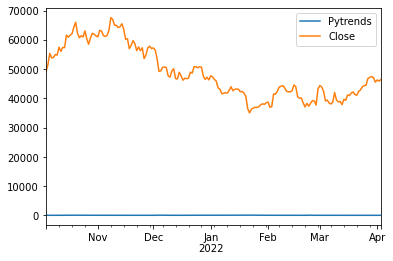

In [12]:
join_df.plot()

In [13]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [14]:
# Predict Closing Prices using a 10 day window of previous closing prices
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 10

# Column index 0 is the 'pytrends' column
# Column index 1 is the `Close` column
feature_column = 0
target_column = 1
X, y = window_data(join_df, window_size, feature_column, target_column)

In [15]:
# Use 70% of the data for training and the remaineder for testing
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [16]:
# Use the MinMaxScaler to scale data between 0 and 1.
from sklearn.preprocessing import MinMaxScaler

# Create MinMaxScaler object
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with training feature data X_train
scaler.fit(X_train)

# Scale features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit MinMaxScaler object with training target data y_train
scaler.fit(y_train)

# Scale target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)


In [17]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [18]:
# Import required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [19]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Note: The dropouts help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features

# Defining LSTM RNN model
model = Sequential()

number_units = 5
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 2.5 (Working with Lavina/Tutor)
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))


# Output layer
model.add(Dense(1))

In [20]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [21]:
# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 5)             140       
                                                                 
 dropout (Dropout)           (None, 10, 5)             0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 5)             220       
                                                                 
 dropout_1 (Dropout)         (None, 10, 5)             0         
                                                                 
 lstm_2 (LSTM)               (None, 10, 5)             220       
                                                                 
 dropout_2 (Dropout)         (None, 10, 5)             0         
                                                                 
 lstm_3 (LSTM)               (None, 5)                 2

In [22]:
# Train the model
# Use at least 10 epochs
# Do not shuffle the data
# Experiement with the batch size, but a smaller batch size is recommended
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)

Epoch 1/10
119/119 [==============================] - 5s 21ms/step - loss: 0.1337
Epoch 2/10
119/119 [==============================] - 2s 20ms/step - loss: 0.0569
Epoch 3/10
119/119 [==============================] - 2s 20ms/step - loss: 0.0554
Epoch 4/10
119/119 [==============================] - 2s 20ms/step - loss: 0.0540
Epoch 5/10
119/119 [==============================] - 2s 20ms/step - loss: 0.0507
Epoch 6/10
119/119 [==============================] - 2s 20ms/step - loss: 0.0462
Epoch 7/10
119/119 [==============================] - 2s 20ms/step - loss: 0.0418
Epoch 8/10
119/119 [==============================] - 2s 19ms/step - loss: 0.0379
Epoch 9/10
119/119 [==============================] - 2s 20ms/step - loss: 0.0347
Epoch 10/10
119/119 [==============================] - 2s 20ms/step - loss: 0.0321


In [23]:
# Evaluate the model
model.evaluate(X_test, y_test)

2/2 [==============================] - 1s 74ms/step - loss: 0.0152


0.015182885341346264

In [24]:
# Make some predictions
predicted = model.predict(X_test)

In [25]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [26]:
# Create a DataFrame of Real and Predicted values
first_df = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = join_df.index[-len(real_prices): ]) 
first_df

,Real,Predicted
2022-02-11,43565.11328,38253.171875
2022-02-12,42407.93750,38425.636719
2022-02-13,42244.46875,38620.929688
2022-02-14,42197.51563,38924.738281
2022-02-15,42586.91797,39238.988281
2022-02-16,44575.20313,39327.445312
2022-02-17,43961.85938,39417.308594
2022-02-18,40538.01172,39453.765625
2022-02-19,40030.97656,39402.386719
2022-02-20,40122.15625,39321.738281


<AxesSubplot:>

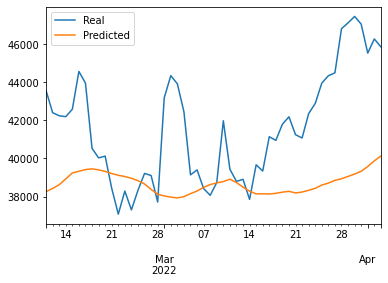

In [27]:
# Plot the real vs predicted values as a line chart
first_df.plot()

In [28]:
# Model #2

In [29]:
# Making adjustments based on Epochs.

In [30]:
#Accoridng to class notes, more epochs cis a strategy for improving a models accuracy.

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 5)             140       
                                                                 
 dropout (Dropout)           (None, 10, 5)             0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 5)             220       
                                                                 
 dropout_1 (Dropout)         (None, 10, 5)             0         
                                                                 
 lstm_2 (LSTM)               (None, 10, 5)             220       
                                                                 
 dropout_2 (Dropout)         (None, 10, 5)             0         
                                                                 
 lstm_3 (LSTM)               (None, 5)                 2

In [32]:
model.fit(X_train, y_train, epochs=100, shuffle=False, batch_size=1, verbose=1)

Epoch 1/100
119/119 [==============================] - 2s 20ms/step - loss: 0.0300
Epoch 2/100
119/119 [==============================] - 2s 20ms/step - loss: 0.0283
Epoch 3/100
119/119 [==============================] - 3s 21ms/step - loss: 0.0268
Epoch 4/100
119/119 [==============================] - 2s 21ms/step - loss: 0.0256
Epoch 5/100
119/119 [==============================] - 2s 21ms/step - loss: 0.0245
Epoch 6/100
119/119 [==============================] - 2s 19ms/step - loss: 0.0237
Epoch 7/100
119/119 [==============================] - 3s 21ms/step - loss: 0.0230
Epoch 8/100
119/119 [==============================] - 3s 21ms/step - loss: 0.0224
Epoch 9/100
119/119 [==============================] - 2s 21ms/step - loss: 0.0219
Epoch 10/100
119/119 [==============================] - 2s 20ms/step - loss: 0.0215
Epoch 11/100
119/119 [==============================] - 2s 20ms/step - loss: 0.0211
Epoch 12/100
119/119 [==============================] - 3s 21ms/step - loss: 0.0208
E

In [33]:
model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 15ms/step - loss: 0.0090


0.009018583223223686

In [34]:
predicted = model.predict(X_test)


In [35]:
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [36]:
second_df = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = join_df.index[-len(real_prices): ]) 
second_df

,Real,Predicted
2022-02-11,43565.11328,45934.492188
2022-02-12,42407.93750,45095.773438
2022-02-13,42244.46875,43866.609375
2022-02-14,42197.51563,43044.292969
2022-02-15,42586.91797,42904.519531
2022-02-16,44575.20313,43210.148438
2022-02-17,43961.85938,44355.269531
2022-02-18,40538.01172,44852.929688
2022-02-19,40030.97656,43608.789062
2022-02-20,40122.15625,42485.531250


<AxesSubplot:>

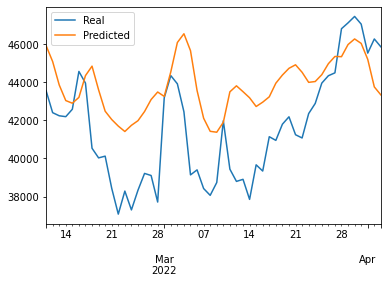

In [37]:
second_df.plot()

In [38]:
# With 100 epochs we see a a greater accuracy

In [39]:
#3 500 Epochs

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 5)             140       
                                                                 
 dropout (Dropout)           (None, 10, 5)             0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 5)             220       
                                                                 
 dropout_1 (Dropout)         (None, 10, 5)             0         
                                                                 
 lstm_2 (LSTM)               (None, 10, 5)             220       
                                                                 
 dropout_2 (Dropout)         (None, 10, 5)             0         
                                                                 
 lstm_3 (LSTM)               (None, 5)                 2

In [41]:
model.fit(X_train, y_train, epochs=500, shuffle=False, batch_size=1, verbose=1)

Epoch 1/500
119/119 [==============================] - 2s 21ms/step - loss: 0.0032
Epoch 2/500
119/119 [==============================] - 3s 22ms/step - loss: 0.0031
Epoch 3/500
119/119 [==============================] - 3s 21ms/step - loss: 0.0031
Epoch 4/500
119/119 [==============================] - 2s 21ms/step - loss: 0.0031
Epoch 5/500
119/119 [==============================] - 2s 20ms/step - loss: 0.0030
Epoch 6/500
119/119 [==============================] - 2s 20ms/step - loss: 0.0030
Epoch 7/500
119/119 [==============================] - 2s 20ms/step - loss: 0.0030
Epoch 8/500
119/119 [==============================] - 2s 20ms/step - loss: 0.0030
Epoch 9/500
119/119 [==============================] - 2s 20ms/step - loss: 0.0030
Epoch 10/500
119/119 [==============================] - 2s 20ms/step - loss: 0.0029
Epoch 11/500
119/119 [==============================] - 2s 20ms/step - loss: 0.0029
Epoch 12/500
119/119 [==============================] - 2s 20ms/step - loss: 0.0029
E

KeyboardInterrupt: 

In [ ]:
model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 4ms/step - loss: 0.0026


0.0026119465474039316

In [ ]:
predicted = model.predict(X_test)

In [ ]:
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
third_df = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = join_df.index[-len(real_prices): ]) 
third_df

,Real,Predicted
2022-02-11,43565.11328,43873.570312
2022-02-12,42407.93750,43001.320312
2022-02-13,42244.46875,41543.988281
2022-02-14,42197.51563,41893.238281
2022-02-15,42586.91797,41176.847656
2022-02-16,44575.20313,41655.687500
2022-02-17,43961.85938,43749.492188
2022-02-18,40538.01172,43088.160156
2022-02-19,40030.97656,40312.121094
2022-02-20,40122.15625,40298.812500


<AxesSubplot:>

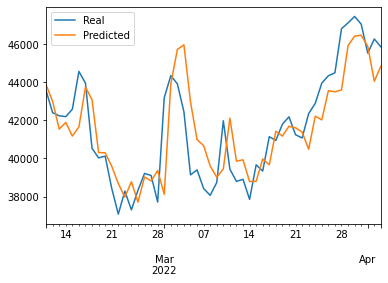

In [ ]:
third_df.plot()

In [ ]:
#Model 4 1000 epochs

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 5)             140       
                                                                 
 dropout (Dropout)           (None, 10, 5)             0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 5)             220       
                                                                 
 dropout_1 (Dropout)         (None, 10, 5)             0         
                                                                 
 lstm_2 (LSTM)               (None, 5)                 220       
                                                                 
 dropout_2 (Dropout)         (None, 5)                 0         
                                                                 
 dense (Dense)               (None, 1)                 6

In [ ]:
model.fit(X_train, y_train, epochs=1000, shuffle=False, batch_size=1, verbose=1)

Epoch 1/1000
119/119 [==============================] - 0s 4ms/step - loss: 0.0083
Epoch 2/1000
119/119 [==============================] - 0s 4ms/step - loss: 0.0067
Epoch 3/1000
119/119 [==============================] - 0s 4ms/step - loss: 0.0077
Epoch 4/1000
119/119 [==============================] - 0s 4ms/step - loss: 0.0065
Epoch 5/1000
119/119 [==============================] - 0s 4ms/step - loss: 0.0063
Epoch 6/1000
119/119 [==============================] - 0s 4ms/step - loss: 0.0068
Epoch 7/1000
119/119 [==============================] - 0s 4ms/step - loss: 0.0075
Epoch 8/1000
119/119 [==============================] - 0s 4ms/step - loss: 0.0088
Epoch 9/1000
119/119 [==============================] - 0s 4ms/step - loss: 0.0069
Epoch 10/1000
119/119 [==============================] - 0s 4ms/step - loss: 0.0070
Epoch 11/1000
119/119 [==============================] - 0s 4ms/step - loss: 0.0070
Epoch 12/1000
119/119 [==============================] - 0s 4ms/step - loss: 0.0073
E

In [ ]:
model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 3ms/step - loss: 0.0063


0.006262533832341433

In [ ]:
predicted = model.predict(X_test)

In [ ]:
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
fourth_df = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = join_df.index[-len(real_prices): ]) 
fourth_df

,Real,Predicted
2022-02-11,43565.11328,43527.507812
2022-02-12,42407.93750,41869.355469
2022-02-13,42244.46875,40592.785156
2022-02-14,42197.51563,39823.917969
2022-02-15,42586.91797,39955.960938
2022-02-16,44575.20313,40094.562500
2022-02-17,43961.85938,42970.929688
2022-02-18,40538.01172,43279.921875
2022-02-19,40030.97656,41070.875000
2022-02-20,40122.15625,40810.675781


<AxesSubplot:>

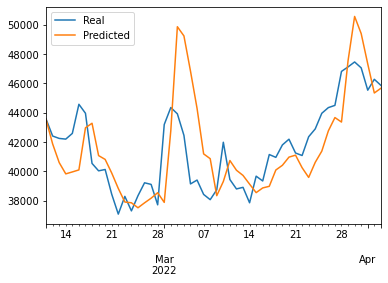

In [ ]:
fourth_df.plot()

In [ ]:
#Model #5 Almost there! 300 Epochs (this should generate a .003)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 5)             140       
                                                                 
 dropout (Dropout)           (None, 10, 5)             0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 5)             220       
                                                                 
 dropout_1 (Dropout)         (None, 10, 5)             0         
                                                                 
 lstm_2 (LSTM)               (None, 5)                 220       
                                                                 
 dropout_2 (Dropout)         (None, 5)                 0         
                                                                 
 dense (Dense)               (None, 1)                 6

In [ ]:
model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 0s/step - loss: 0.0063


0.006262533832341433

In [ ]:
model.fit(X_train, y_train, epochs=300, shuffle=False, batch_size=1, verbose=1)

Epoch 1/300
119/119 [==============================] - 0s 4ms/step - loss: 0.0071
Epoch 2/300
119/119 [==============================] - 0s 4ms/step - loss: 0.0071
Epoch 3/300
119/119 [==============================] - 0s 4ms/step - loss: 0.0065
Epoch 4/300
119/119 [==============================] - 0s 4ms/step - loss: 0.0077
Epoch 5/300
119/119 [==============================] - 0s 4ms/step - loss: 0.0065
Epoch 6/300
119/119 [==============================] - 0s 4ms/step - loss: 0.0066
Epoch 7/300
119/119 [==============================] - 0s 4ms/step - loss: 0.0064
Epoch 8/300
119/119 [==============================] - 0s 4ms/step - loss: 0.0063
Epoch 9/300
119/119 [==============================] - 0s 4ms/step - loss: 0.0057
Epoch 10/300
119/119 [==============================] - 0s 4ms/step - loss: 0.0069
Epoch 11/300
119/119 [==============================] - 0s 4ms/step - loss: 0.0065
Epoch 12/300
119/119 [==============================] - 0s 4ms/step - loss: 0.0061
Epoch 13/300


In [ ]:
model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 3ms/step - loss: 0.0095


0.009476890787482262

In [ ]:
predicted = model.predict(X_test)

In [ ]:
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
fifth_df = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = join_df.index[-len(real_prices): ]) 
fifth_df

,Real,Predicted
2022-02-11,43565.11328,44372.859375
2022-02-12,42407.93750,42418.679688
2022-02-13,42244.46875,41446.968750
2022-02-14,42197.51563,40485.406250
2022-02-15,42586.91797,40815.519531
2022-02-16,44575.20313,40769.210938
2022-02-17,43961.85938,43803.738281
2022-02-18,40538.01172,44207.617188
2022-02-19,40030.97656,42220.167969
2022-02-20,40122.15625,41926.574219


<AxesSubplot:>

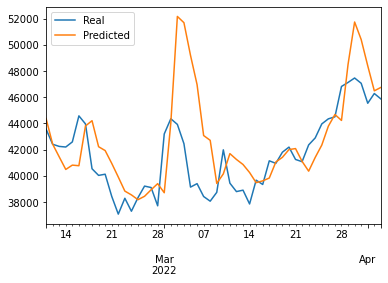

In [ ]:
fifth_df.plot()

In [ ]:
#Adding Additional Layers

In [ ]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Note: The dropouts help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features

# Defining LSTM RNN model
model = Sequential()

number_units = 5
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))



# Output layer
model.add(Dense(1))

NameError: name 'Sequential' is not defined

In [ ]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [ ]:
# Summarize the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 10, 5)             140       
                                                                 
 dropout_3 (Dropout)         (None, 10, 5)             0         
                                                                 
 lstm_4 (LSTM)               (None, 10, 5)             220       
                                                                 
 dropout_4 (Dropout)         (None, 10, 5)             0         
                                                                 
 lstm_5 (LSTM)               (None, 5)                 220       
                                                                 
 dropout_5 (Dropout)         (None, 5)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [ ]:
# Train the model
# Use at least 10 epochs
# Do not shuffle the data
# Experiement with the batch size, but a smaller batch size is recommended
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)

Epoch 1/10
119/119 [==============================] - 3s 5ms/step - loss: 0.1927
Epoch 2/10
119/119 [==============================] - 1s 4ms/step - loss: 0.0647
Epoch 3/10
119/119 [==============================] - 0s 4ms/step - loss: 0.0612
Epoch 4/10
119/119 [==============================] - 0s 4ms/step - loss: 0.0441
Epoch 5/10
119/119 [==============================] - 1s 4ms/step - loss: 0.0650
Epoch 6/10
119/119 [==============================] - 0s 4ms/step - loss: 0.0552
Epoch 7/10
119/119 [==============================] - 1s 4ms/step - loss: 0.0504
Epoch 8/10
119/119 [==============================] - 1s 4ms/step - loss: 0.0410
Epoch 9/10
119/119 [==============================] - 0s 4ms/step - loss: 0.0430
Epoch 10/10
119/119 [==============================] - 1s 5ms/step - loss: 0.0351


In [ ]:
# Evaluate the model
model.evaluate(X_test, y_test)

2/2 [==============================] - 1s 0s/step - loss: 0.0097


0.009691462852060795